## Importing the Required Libraries

In [48]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import cv2
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import os
import warnings
warnings.filterwarnings('ignore')

## Loading the Dataset

In [3]:
dir = 'data-set/'

label = []
path = []

for dirname, _,filenames in os.walk(dir):
    for filename in filenames:
        label.append(os.path.split(dirname)[1])
        path.append(os.path.join(dirname,filename))

In [4]:
dataset = pd.DataFrame(columns=['Image','Label'])
dataset['Image']=path
dataset['Label']=label
dataset = shuffle(dataset)
dataset = dataset.reset_index(drop=True)

## Exploratory Data Analysis (EDA)

### Checking some statistics 

In [5]:
len(dataset)

11525

In [6]:
dataset.head()

Image       Label
0    data-set/maleeyes/4779.jpg    maleeyes
1  data-set/femaleeyes/1418.jpg  femaleeyes
2    data-set/maleeyes/3583.jpg    maleeyes
3    data-set/maleeyes/7397.jpg    maleeyes
4     data-set/maleeyes/442.jpg    maleeyes

In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11525 entries, 0 to 11524
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Image   11525 non-null  object
 1   Label   11525 non-null  object
dtypes: object(2)
memory usage: 180.2+ KB


In [8]:
dataset.describe()

Image     Label
count                        11525     11525
unique                       11525         2
top     data-set/maleeyes/4779.jpg  maleeyes
freq                             1      6323

### Checking for nulls

In [9]:
dataset.isna().sum()

Image    0
Label    0
dtype: int64

### Displaying first 15 images

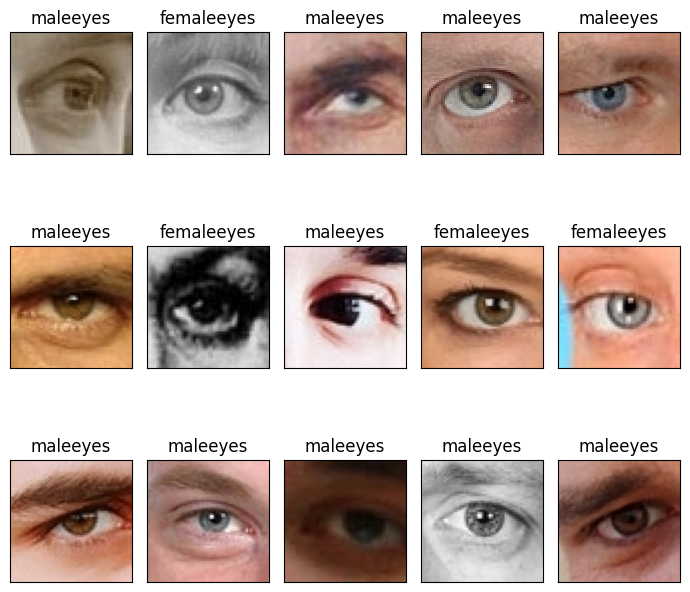

In [10]:
fig, axes = plt.subplots(nrows = 3,
                        ncols = 5,
                        figsize = (7, 7),
                        subplot_kw = {"xticks":[],"yticks":[]})

for i,ax in enumerate(axes.flat):
    ax.imshow(plt.imread(dataset["Image"][i]))
    ax.set_title(dataset["Label"][i])
plt.tight_layout()
plt.show()

### Checking data distribution

Label
maleeyes      6323
femaleeyes    5202
Name: count, dtype: int64


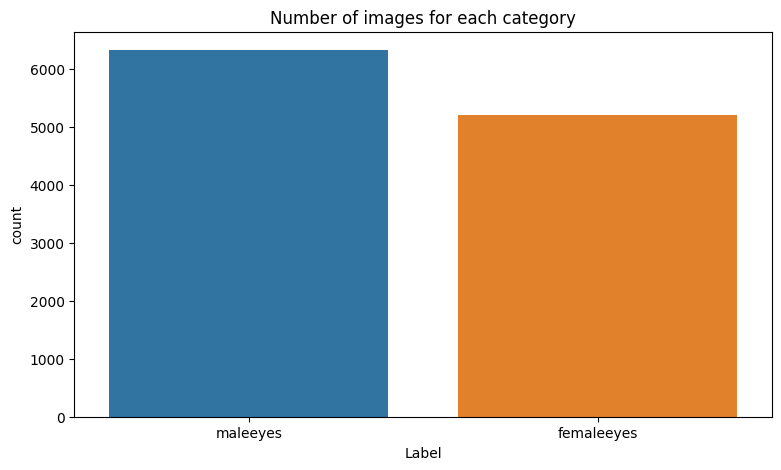

In [11]:
td = dataset['Label'].value_counts()
print(td)

plt.figure(figsize = (9, 5))
sns.barplot(x = td.index, y = td)
plt.title("Number of images for each category")
plt.show()

There are total of 11525 Images in the entire dataset, having 2 labels [maleeyes, femaleeyes]. Frequency of maleeyes  is greater then frequency of femaleeyes.

It is clear from the above plot that there is an imbalance in the dataset. We will now perform downsampling to balance the dataset.

### Balancing  dataset



In [12]:
df_male = dataset[dataset.Label=='maleeyes']
len(df_male)

6323

In [13]:
df_female = dataset[dataset.Label=='femaleeyes']
len(df_female)

5202

### Downsampling without replacing

In [14]:
df_down_sample = resample(df_male, replace=False, n_samples=5202, random_state=42)
dataset = pd.concat([df_down_sample, df_female])
dataset = shuffle(dataset)
dataset = dataset.reset_index(drop=True)

In [15]:
print(dataset.Label.value_counts())
dataset.describe()

Label
femaleeyes    5202
maleeyes      5202
Name: count, dtype: int64


Image       Label
count                        10404       10404
unique                       10404           2
top     data-set/femaleeyes/84.jpg  femaleeyes
freq                             1        5202

Label
femaleeyes    5202
maleeyes      5202
Name: count, dtype: int64


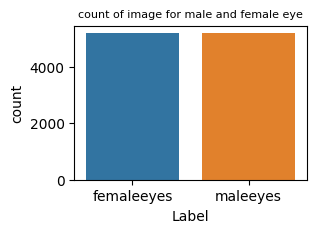

In [16]:
ds = dataset['Label'].value_counts()
print(ds)
plt.figure(figsize = (3, 2))
sns.barplot(x = ds.index, y = ds)
plt.title("count of image for male and female eye", fontsize = 8)
plt.show()

Now we have a balanced data set

### Preparing the Data for model traing

Changing all image dimensions to (64x64) and converting to grayscale

In [17]:
size = (64,64)
# duplicating original dataframe
dfcopy = dataset.copy() 
size_list = set()
for i in range(len(dataset)):
    image=cv2.imread(dataset['Image'][i])
    image=cv2.resize(image,size)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    size_list.add(image.shape)
    dfcopy['Image'][i] = image.flatten()

size_list 

{(64, 64, 3)}

### Transform target label

In [18]:
labelEnc = LabelEncoder()
dfcopy['Label'] = np.asarray(labelEnc.fit_transform(dfcopy['Label']))
dfcopy.head()

Image  Label
0  [135, 135, 135, 139, 139, 139, 137, 137, 137, ...      0
1  [243, 203, 195, 241, 201, 191, 241, 198, 189, ...      0
2  [199, 152, 134, 200, 153, 135, 197, 146, 131, ...      1
3  [203, 165, 146, 194, 157, 138, 188, 148, 129, ...      1
4  [106, 54, 40, 126, 73, 58, 137, 82, 67, 150, 9...      0

## Benchmark model (SVM Classifier from Sklearn)

In [19]:
images = []
labels = []
for i in range(len(dataset)):
    image = np.array(Image.open(dataset.Image[i]).resize((64, 64)))
    images.append(image)
    labels.append(0 if dataset.Label[i] == 'femaleeyes' else 1)   
X = np.array(images)
y = np.array(labels)

### Split the data into training and testing set

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

### SVM model training

In [31]:
svm = SVC(kernel='linear', random_state=42)

svm.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

### Making predictions

In [32]:
y_pred=svm.predict(X_test)

### Classification report of SVM model

In [34]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.82      0.79      0.80      1616
           1       0.78      0.81      0.80      1506

    accuracy                           0.80      3122
   macro avg       0.80      0.80      0.80      3122
weighted avg       0.80      0.80      0.80      3122



### Confusion matrix

[[1282  289]
 [ 334 1217]]


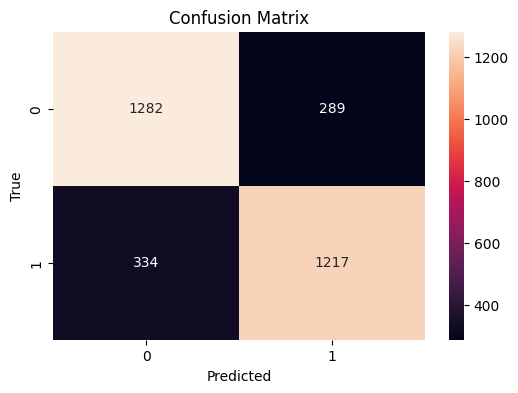

In [38]:
confusionmatrix = confusion_matrix(y_test, y_pred)
print(confusionmatrix)
plt.figure(figsize = (6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred),annot = True, fmt = 'd')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

### Observations

SVM Model gives an average precision of 80%, recall of 79% and f1-score and accuracy of about 0.80.

CLassification reoprts states that model has done a pretty good work in predicition whwere the values of precsion ,recall and F1 score ranges around 80%.

Confusion matrix is plotted where 1282+1217 labels were correctly identified while 289+334 were misclassified.

## Multilayer Perceptron Model

#### Funtion that will reshape the arrray and reset index 

In [39]:
def cleaned(X):
    for i in range(len(X)):
        X[i] = np.vstack(X[i].reset_index(drop=True))
    return X

In [40]:
X_train2, X_val2, y_train2, y_val2 = train_test_split(dfcopy.Image, dfcopy.Label,
                                                      test_size = 0.4, random_state = 7)
X_val2, X_test2,y_val2, y_test2 = train_test_split(X_val2, y_val2, test_size = 0.5, random_state = 7)

In [41]:
x_train2, x_val2, x_test2, y_train2, y_val2, y_test2 = cleaned([X_train2, X_val2, X_test2, y_train2, y_val2, y_test2])

### Model architechture

We are using Leaky Relu and sigmoid activation functions. Leaky Relu is similar to ReLU, but instead of returning 0 for negative inputs, it returns a small negative value. This will help us to address the "dying ReLU" problem, where ReLU neurons can become permanently inactive during training.

In [42]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1024, activation=tf.nn.leaky_relu), 
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation=tf.nn.leaky_relu), 
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid') 
])

### Calculating weight of classes

In [43]:
male = len(y_train2[y_train2>0])
female = len(y_train2) - male
total = len(y_train2)

In [44]:
weight_for_male = total / (2 * male) 
weight_for_female = total / (2 * female)
class_weight = {0: weight_for_female, 1: weight_for_male}
print(class_weight)

{0: 0.9942656897100988, 1: 1.0058008378988077}


### Compiling the model 

Compiling the model using the binary cross-entropy loss function and the adam optimizer, and specifying that we want to track the accuracy, precision, recall and auc metric during training

In [45]:
model.compile(
    optimizer='adam', loss='binary_crossentropy',
    metrics=[
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc')
    ]
)

### Training MLP model

In [49]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train2)

In [50]:
model_fit = model.fit(x_train_scaled, y_train2, class_weight=class_weight, batch_size=64,
                validation_data=(x_val2, y_val2),
                epochs=25)

Epoch 1/25
98/98 [==============================] - 11s 105ms/step - loss: 6.8358 - accuracy: 0.7003 - precision: 0.6951 - recall: 0.7074 - auc: 0.7240 - val_loss: 184.9996 - val_accuracy: 0.7732 - val_precision: 0.8537 - val_recall: 0.6654 - val_auc: 0.7763
Epoch 2/25
98/98 [==============================] - 10s 103ms/step - loss: 4.4539 - accuracy: 0.7701 - precision: 0.7651 - recall: 0.7757 - auc: 0.7927 - val_loss: 1934.1057 - val_accuracy: 0.4945 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000
Epoch 3/25
98/98 [==============================] - 10s 103ms/step - loss: 2.0689 - accuracy: 0.8012 - precision: 0.7980 - recall: 0.8034 - auc: 0.8411 - val_loss: 70.5328 - val_accuracy: 0.7665 - val_precision: 0.8426 - val_recall: 0.6616 - val_auc: 0.7714
Epoch 4/25
98/98 [==============================] - 10s 104ms/step - loss: 1.4892 - accuracy: 0.8037 - precision: 0.7960 - recall: 0.8137 - auc: 0.8588 - val_loss: 277.2559 - val_accuracy: 0.5296 - val_precision: 0.

### Making predictions

In [51]:
x_test_scaled = scaler.fit_transform(x_test2)
y_pred2 = model.predict(x_test_scaled)
y_pred2 = np.where(y_pred2 > 0.5, 1, 0)

66/66 [==============================] - 0s 6ms/step


### Training and testing loss

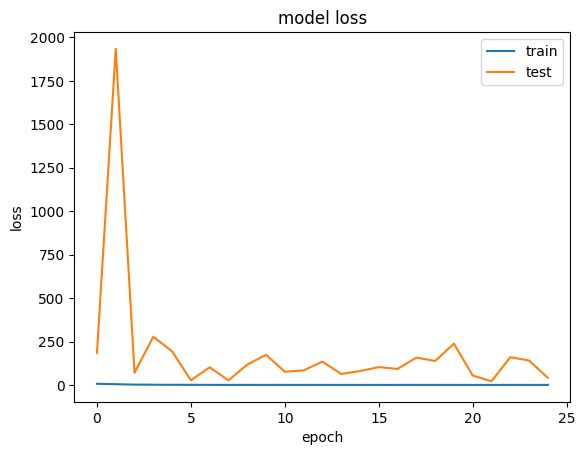

In [52]:
plt.plot(model_fit.history['loss'])
plt.plot(model_fit.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### Training and testing accuracy

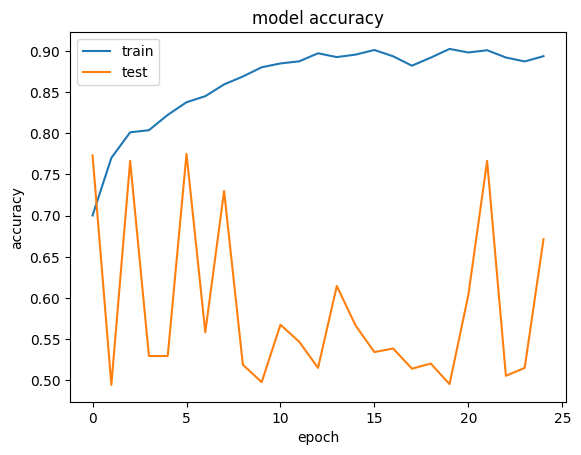

In [53]:
plt.plot(model_fit.history['accuracy'])
plt.plot(model_fit.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('model accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Classification report of MLP model

In [54]:
model_classification_report = classification_report(y_test2,y_pred2)
print(model_classification_report)

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      1034
           1       0.88      0.85      0.87      1047

    accuracy                           0.87      2081
   macro avg       0.87      0.87      0.87      2081
weighted avg       0.87      0.87      0.87      2081



### Confusion matrix of MLP model

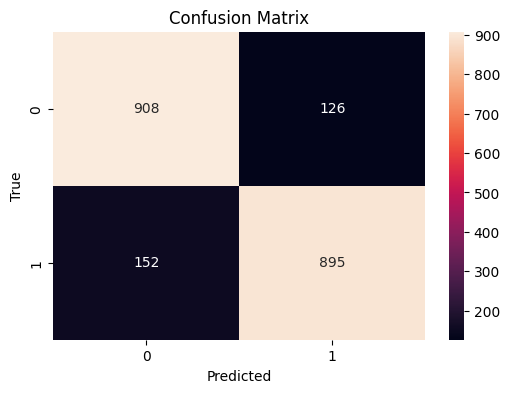

In [55]:
plt.figure(figsize = (6, 4))

sns.heatmap(confusion_matrix(y_test2, y_pred2),annot = True, fmt = 'd')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()

### Observations

We are using a sequential model is created using keras using from tensorflow.keras.models import Sequential.
the input are flattened to perform better and faster.

The first layer is a dense layer with 1024 units and a leaky rectified linear unit (leaky_relu) activation function, and takes the input data as input. We have then added a dropout layer with a dropout rate of 0.5 to prevent overfitting. adding another dense layer with 512 units and a leaky_relu activation function, followed by another dropout layer. Finally, we add a dense layer with 1 unit and a sigmoid activation function, which will outputs the predicted class probabilities(as 0 or 1).

The Training accuracy improved from 62% to 87% and Training loss improved from 0.65 to 0.27.
Similarly the Validation accuracy improved from 63% to 81% and Validation loss from 0.64 to 0.40.

An accuracy of 87% is acheived using MLP.

CLassification reoprts states that model has done a pretty good work in predicition where the values of precsion ,recall and F1 score ranges between 80-89%.

Confusion matrix is plotted where 908+895 labels were correctly identified.

## CNN model

In [56]:
def to_tensor(_list):
    LIST = []
    for i in range(len(_list)):
        LIST.append(tf.convert_to_tensor(_list[i]))
    return LIST

In [67]:
def cleaned2(X):
    for i in range(len(X)):
        X[i] = np.stack(X[i].reset_index(drop=True))
    return X

In [60]:
size = (64,64)
dfcopy2 = dataset.copy()
for i in range(len(dataset)):
    image=cv2.imread(dataset['Image'][i])
    image=cv2.resize(image,size)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    dfcopy2['Image'][i] = image

In [61]:
labelencoder = LabelEncoder()
dfcopy2['Label'] = np.asarray(labelencoder.fit_transform(dfcopy2["Label"]))
display(dfcopy2.head())

Image  Label
0  [[[135, 135, 135], [139, 139, 139], [137, 137,...      0
1  [[[243, 203, 195], [241, 201, 191], [241, 198,...      0
2  [[[199, 152, 134], [200, 153, 135], [197, 146,...      1
3  [[[203, 165, 146], [194, 157, 138], [188, 148,...      1
4  [[[106, 54, 40], [126, 73, 58], [137, 82, 67],...      0

### Training, testing and validation datasets

In [68]:
x_train3, x_val3, y_train3, y_val3 = train_test_split(dfcopy2.Image, dfcopy2.Label,test_size = 0.4, random_state = 7)
x_val3, x_test3, y_val3, y_test3 = train_test_split(x_val3, y_val3, test_size = 0.5, random_state = 7)

x_train3, x_val3, x_test3, y_train3, y_val3, y_test3 = cleaned2([x_train3, x_val3, x_test3,y_train3, y_val3, y_test3])
x_train3, x_val3, x_test3, y_train3, y_val3, y_test3 = to_tensor([x_train3, x_val3, x_test3,y_train3, y_val3, y_test3])

### Model architechture

We are using common model architechture for image classification tasks, as it includes several convolutional layers that can extract high-level features from the input image, followed by pooling layers that reduce the spatial dimensions of the feature maps.

In [69]:
myCNNmodel=keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(64,64,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1,activation='sigmoid')  
])

### Compiling and training the model


In [70]:
myCNNmodel.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
cnn_model_fit=myCNNmodel.fit(x_train3, y_train3, validation_data=(x_val3, y_val3), epochs=25)

Epoch 1/25
196/196 [==============================] - 11s 51ms/step - loss: 0.6156 - accuracy: 0.7201 - val_loss: 0.4744 - val_accuracy: 0.7833
Epoch 2/25
196/196 [==============================] - 11s 54ms/step - loss: 0.3798 - accuracy: 0.8361 - val_loss: 0.4040 - val_accuracy: 0.8063
Epoch 3/25
196/196 [==============================] - 11s 57ms/step - loss: 0.3229 - accuracy: 0.8632 - val_loss: 0.2896 - val_accuracy: 0.8866
Epoch 4/25
196/196 [==============================] - 11s 56ms/step - loss: 0.2983 - accuracy: 0.8778 - val_loss: 0.2788 - val_accuracy: 0.8861
Epoch 5/25
196/196 [==============================] - 11s 58ms/step - loss: 0.2506 - accuracy: 0.8986 - val_loss: 0.2602 - val_accuracy: 0.9000
Epoch 6/25
196/196 [==============================] - 12s 60ms/step - loss: 0.2311 - accuracy: 0.9066 - val_loss: 0.2555 - val_accuracy: 0.8972
Epoch 7/25
196/196 [==============================] - 14s 70ms/step - loss: 0.2288 - accuracy: 0.9098 - val_loss: 0.2568 - val_accuracy:

### Training and testing loss

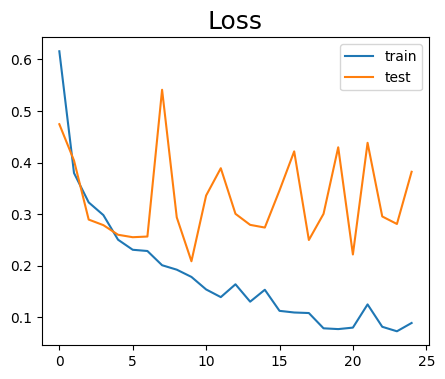

In [71]:
plt.figure(figsize=(5,4))
plt.plot(cnn_model_fit.history['loss'])
plt.plot(cnn_model_fit.history['val_loss'])
plt.title('Loss',fontdict={'size':18})
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### Training and testing accuracy

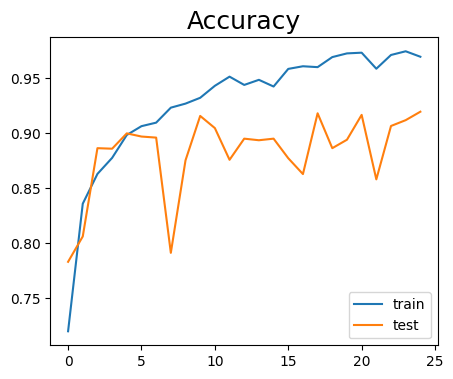

In [72]:
plt.figure(figsize=(5,4))
plt.plot(cnn_model_fit.history['accuracy'])
plt.plot(cnn_model_fit.history['val_accuracy'])
plt.title('Accuracy',fontdict={'size':18})
plt.legend(['train', 'test'], loc='lower right')
plt.show()

### Making predictions

In [73]:
y_pred_myCNN = myCNNmodel.predict(x_test3)
y_pred_myCNN = np.round(y_pred_myCNN)

66/66 [==============================] - 1s 11ms/step


### Classification report of CNN model

In [74]:
myCNN_Classification_Report = classification_report(y_test3, y_pred_myCNN)
print(myCNN_Classification_Report)

              precision    recall  f1-score   support

           0       0.93      0.90      0.92      1034
           1       0.90      0.94      0.92      1047

    accuracy                           0.92      2081
   macro avg       0.92      0.92      0.92      2081
weighted avg       0.92      0.92      0.92      2081



### Confusion matrix

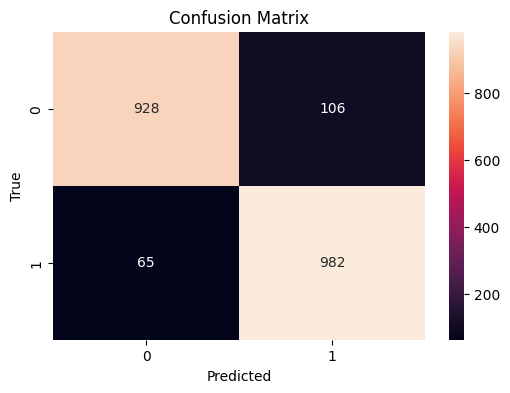

In [75]:
plt.figure(figsize = (6, 4))

sns.heatmap(confusion_matrix(y_test3, y_pred_myCNN),annot = True, fmt = 'd')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()

### Observations

We are using a common model architechture for image classification tasks, as it includes several convolutional layers that can extract high-level features from the input image, followed by pooling layers that reduce the spatial dimensions of the feature maps. The batch normalization layers can help stabilize training, and the dropout layers can help prevent overfitting. The final fully connected layer with a sigmoid activation function can produce a binary classification output. Overall, this architecture has a good balance between model complexity and performance on a wide range of image classification tasks.

A a sequential model is created using keras using from tensorflow.keras.models import Sequential.

The Training accuracy improved from 67% to 92% and Training loss improved from 0.65 to 0.24.
Similarly the Validation accuracy improved from 69% to 92% and Validation loss from 0.65 to 0.22.


CLassification reoprts states that model has done a pretty good work in predicition where the values of precsion ,recall and F1 score ranges between 89 - 95%.

Confusion matrix is plotted where 106+65 records were misclassified. Overall 1910 images were classified by CNNmodel.

## Conclusion

From the above implementation and evalutaion, we can say for this particular model of classifying human eyes with SVM, MLP and CNN , CNN outperformed the other two models

With CNN considering all the features and images, the maximum accuracy achieved was 92%.  It is well suited for this dataset as it has 10k+ records.  It is capable of doing high computational work.  The loss score achieved is 0.1.Thus indicating a super fit model. * The loss decreases and accuracy increases.  

Model can be improved further by hyper parameter tuning and cross validation. Also, different epochs could be implemented. Variations can be checked for and compared.